# Image Segmentation:
- Unet model and combine with transfer learning from VGG-16
- Data is trained on in-built dataset: "Oxford_iiit_pet"
- Perfrom both sementic, instance and phenoptic segmentation

# Need help in debuging the code and also implement on other dataset like COCO

# Here only sementic segemnetation is being tested.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_datasets as tfds

In [2]:
# Load the Oxford-IIIT Pet dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', split='train', shuffle_files=True, with_info=True)

# Determine the number of classes in the segmentation mask
num_classes = info.features['segmentation_mask'].shape[-1]
print(num_classes)
print(info.features)

# Prepare the dataset for training
def preprocess(example):
    image = tf.image.resize(example['image'], (32, 32))
    mask = tf.image.resize(example['segmentation_mask'], (32, 32))
    image = tf.keras.applications.vgg16.preprocess_input(image)
    mask = tf.cast(mask, tf.float32) / 255.0
    return image, mask

dataset = dataset.map(preprocess)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

1
FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


In [3]:
# Separate input features (images) and labels (masks)
input_images = []
labels = []

for image, mask in dataset:
    input_images.append(image)
    labels.append(mask)

input_images = tf.concat(input_images, axis=0)
labels = tf.concat(labels, axis=0)

# Print the shapes of input images and labels
print("Input Images shape:", input_images.shape)
print("Labels shape:", labels.shape)

Input Images shape: (3680, 32, 32, 3)
Labels shape: (3680, 32, 32, 1)


In [4]:
# Load the pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the VGG16 layers
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [5]:
# Build the U-Net model on top of VGG16
conv_layers = base_model.get_layer('block5_conv3').output

x = Conv2D(1024, 3, activation='relu', padding='same')(conv_layers)
x = Conv2D(1024, 3, activation='relu', padding='same')(x)
x = Conv2DTranspose(512, 3, strides=2, activation='relu', padding='same')(x)
# x = Concatenate()([x, base_model.get_layer('block4_conv3').output])
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(x)
# x = Concatenate()([x, base_model.get_layer('block3_conv3').output])
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
# x = Concatenate()([x, base_model.get_layer('block2_conv2').output])
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
# x = Concatenate()([x, base_model.get_layer('block1_conv2').output])
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
output = Conv2D(1, 1, activation='sigmoid')(x)

# Create the segmentation model
model = Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
model.fit(dataset, epochs=epochs)

Epoch 1/10
115/115 [==============================] - 843s 7s/step - loss: 0.2839 - accuracy: 0.0000e+00
Epoch 2/10
115/115 [==============================] - 826s 7s/step - loss: 0.0430 - accuracy: 0.0000e+00
Epoch 3/10
115/115 [==============================] - 826s 7s/step - loss: 0.0423 - accuracy: 0.0000e+00
Epoch 4/10
115/115 [==============================] - 819s 7s/step - loss: 0.0422 - accuracy: 0.0000e+00
Epoch 5/10
115/115 [==============================] - 789s 7s/step - loss: 0.0422 - accuracy: 0.0000e+00
Epoch 6/10
115/115 [==============================] - 830s 7s/step - loss: 0.0422 - accuracy: 0.0000e+00
Epoch 7/10
115/115 [==============================] - 837s 7s/step - loss: 0.0422 - accuracy: 0.0000e+00
Epoch 8/10
115/115 [==============================] - 797s 7s/step - loss: 0.0422 - accuracy: 0.0000e+00
Epoch 9/10
115/115 [==============================] - 769s 7s/step - loss: 0.0422 - accuracy: 0.0000e+00
Epoch 10/10
115/115 [==============================] - 

In [21]:
# Save the trained model
model.save('second_unet__segmentation.h5')

1/1 [==============================] - 1s 806ms/step


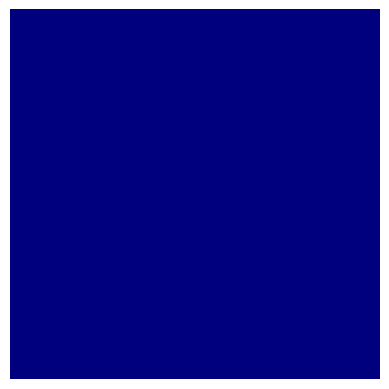

In [23]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model
model = tf.keras.models.load_model('second_unet__segmentation.h5')

# Load or preprocess the image you want to segment
image = plt.imread('catt.jpg')

# Preprocess the image
resized_image = tf.image.resize(image, (32, 32))
preprocessed_image = tf.keras.applications.vgg16.preprocess_input(resized_image)
input_image = np.expand_dims(preprocessed_image, axis=0)

# Predict the segmentation mask
predicted_mask = model.predict(input_image)

# Post-process the predicted mask
threshold = 0.1  # Adjust this threshold as needed
segmented_mask = (predicted_mask > threshold).astype(np.uint8) * 255

# Visualize the segmented image
plt.imshow(segmented_mask.squeeze(), cmap='jet')
plt.axis('off')
plt.show()

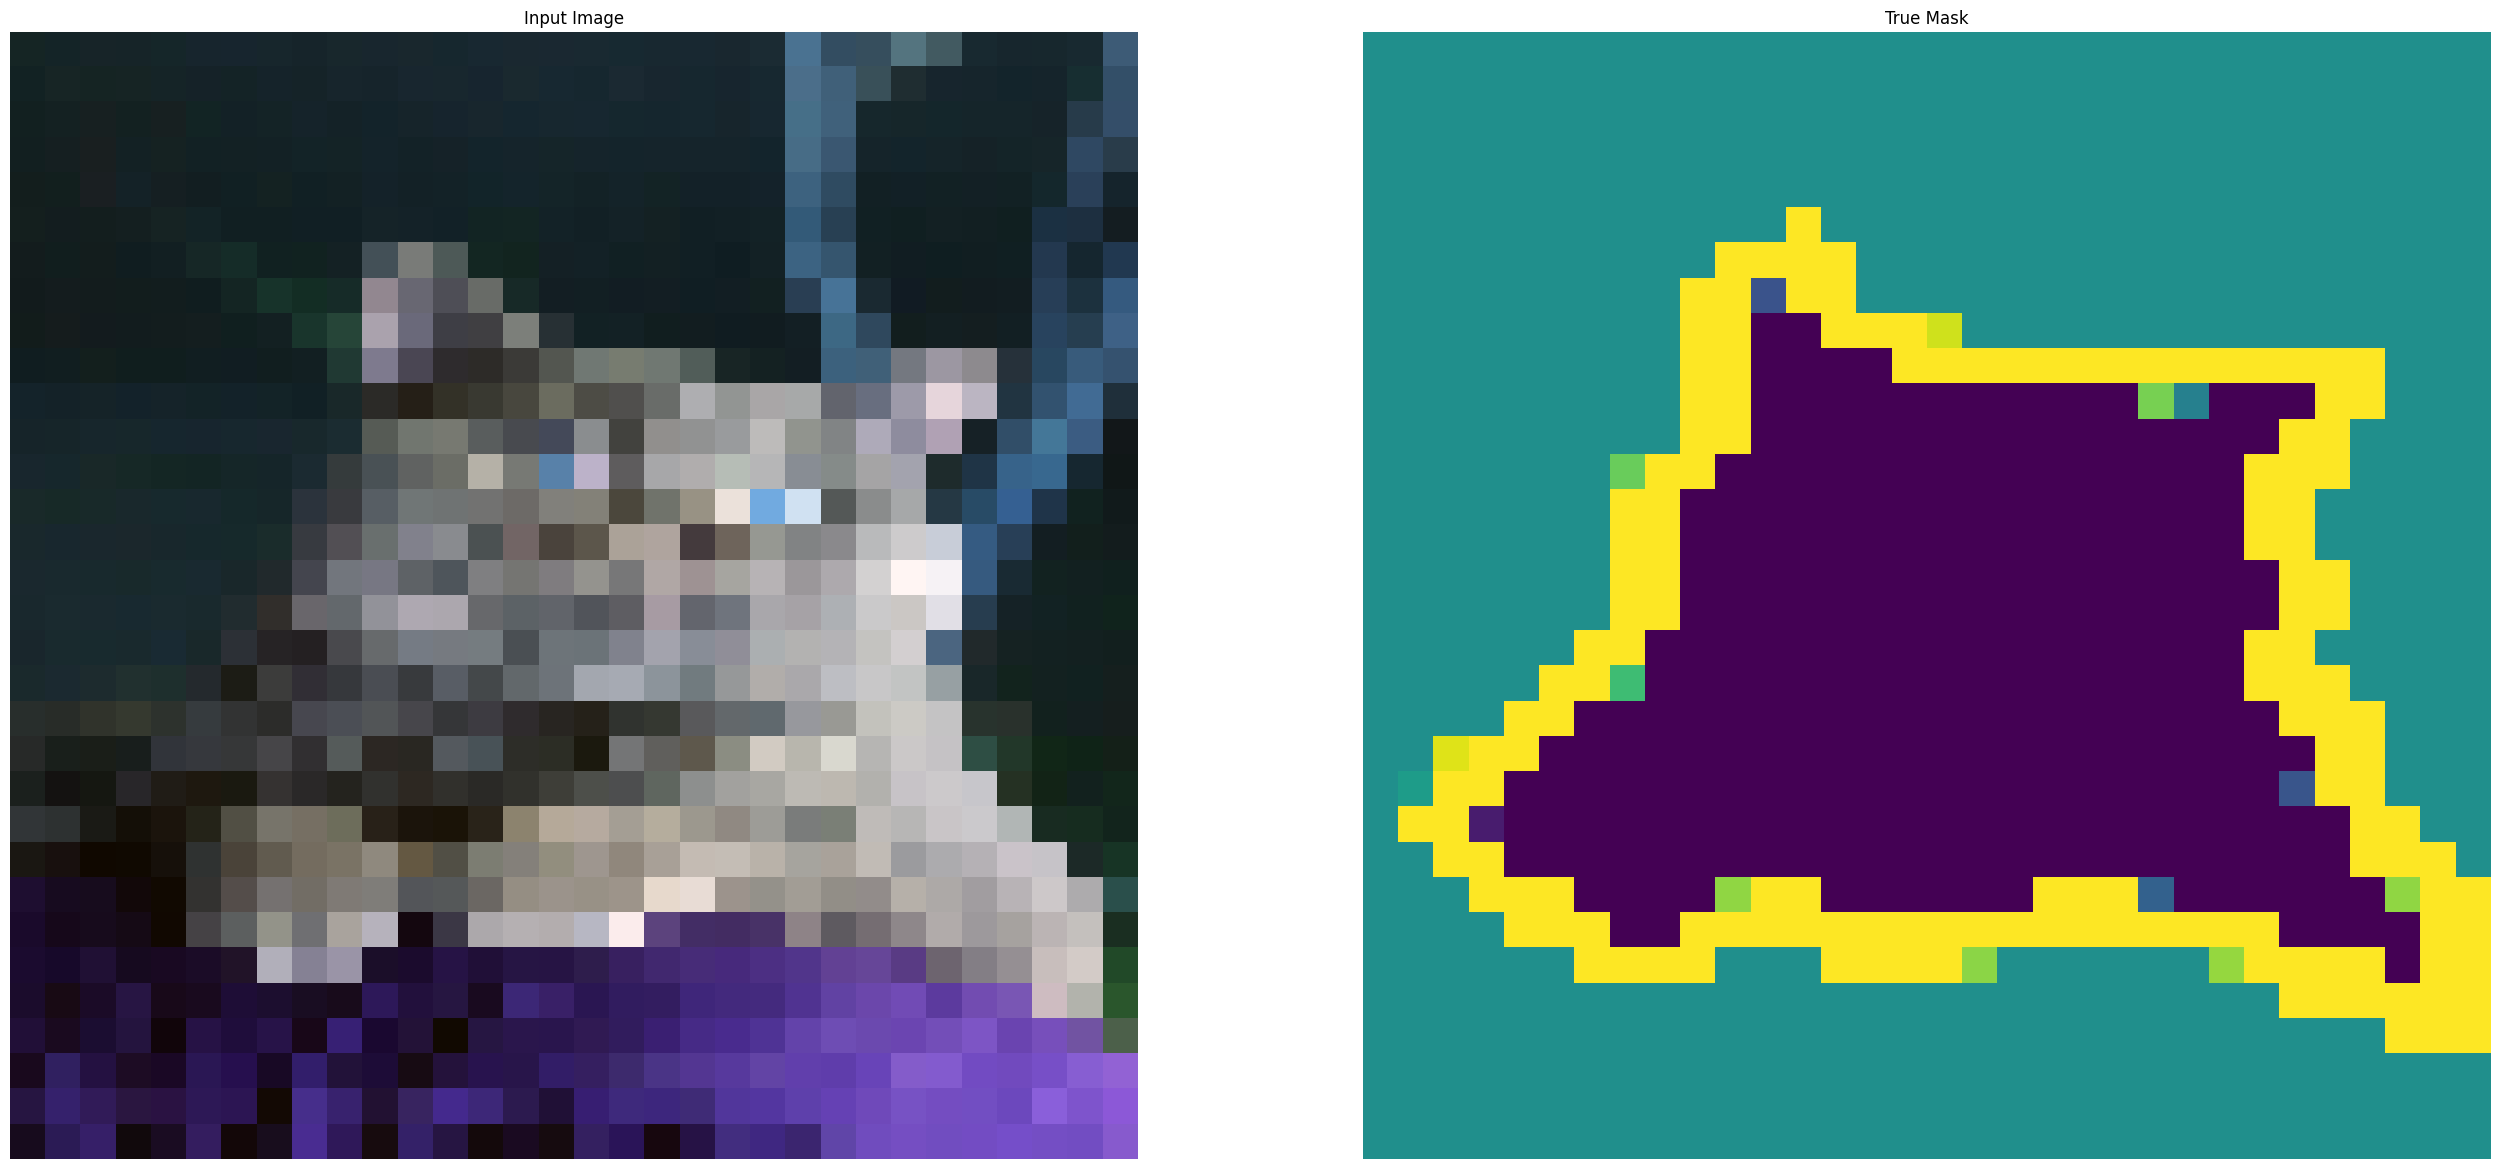

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def display(display_list):
 plt.figure(figsize=(32, 32))
 title = ["Input Image", "True Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(dataset))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])